# Astro R-CNN Demo

Simple example notebook of how to train and run inference Mask R-CNN on PhoSim data

In [1]:
import numpy as np
import matplotlib
from matplotlib.colors import LogNorm
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf

# astro_rcnn
import astro_rcnn
from astro_rcnn import PhoSimDataset
from astro_rcnn import DESConfig
from astro_rcnn import InferenceConfig
from astropy.visualization import make_lupton_rgb

# mrcnn
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn import utils

# Setup directories (see README.md for download links to datasets)
ROOT_DIR = os.path.abspath("./Mask_RCNN")
TEST_DIR = os.path.abspath("./testset/") # test set
REAL_DIR = os.path.abspath("./testset_real/") # real data

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
    
#model path
model_path = os.path.join(MODEL_DIR, "astro_rcnn_decam.h5")

%matplotlib inline

Using TensorFlow backend.


## Create Models

In [2]:
## DATASET

# Test dataset
dataset_test = PhoSimDataset()
dataset_test.load_sources(TEST_DIR,"test",store_raw=True) 
dataset_test.prepare()

Loading images from disk.


# Visualize Data

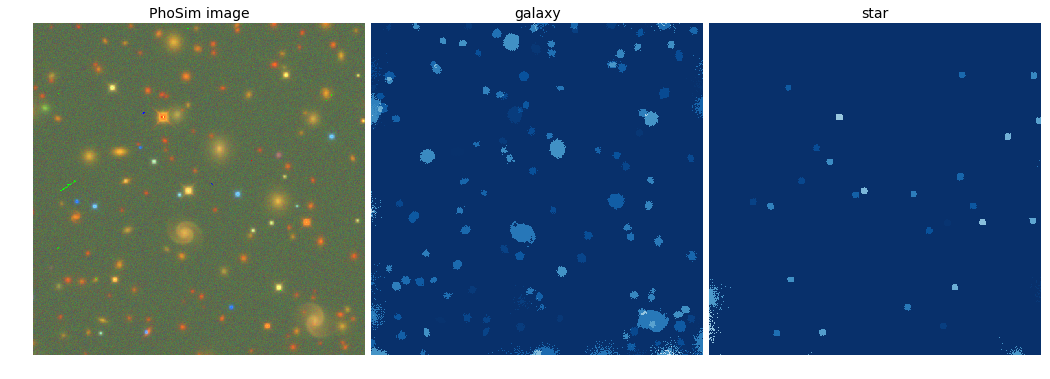

In [3]:
# Load and display random samples
image_id = np.random.choice(dataset_test.image_ids)
image = dataset_test.load_image(image_id)
mask, class_ids = dataset_test.load_mask_disk(image_id)
image_raw = dataset_test.load_image(image_id, raw=True)
im_disp = make_lupton_rgb(image_raw[:,:,0]/1.2, image_raw[:,:,1], image_raw[:,:,2], minimum=0, stretch=50, Q=10) #tune values
visualize.display_top_masks(im_disp, mask, class_ids, dataset_test.class_names,save_fig=True)

## Detection

In [7]:
inference_config = InferenceConfig()
inference_config.display()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        300
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

Processing 1 images
image                    shape: (512, 512, 3)         min: -327.64000  max:  327.67000  float64
molded_images            shape: (1, 512, 512, 3)      min: -127.64001  max:  527.67001  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
Done in 6.15 seconds.


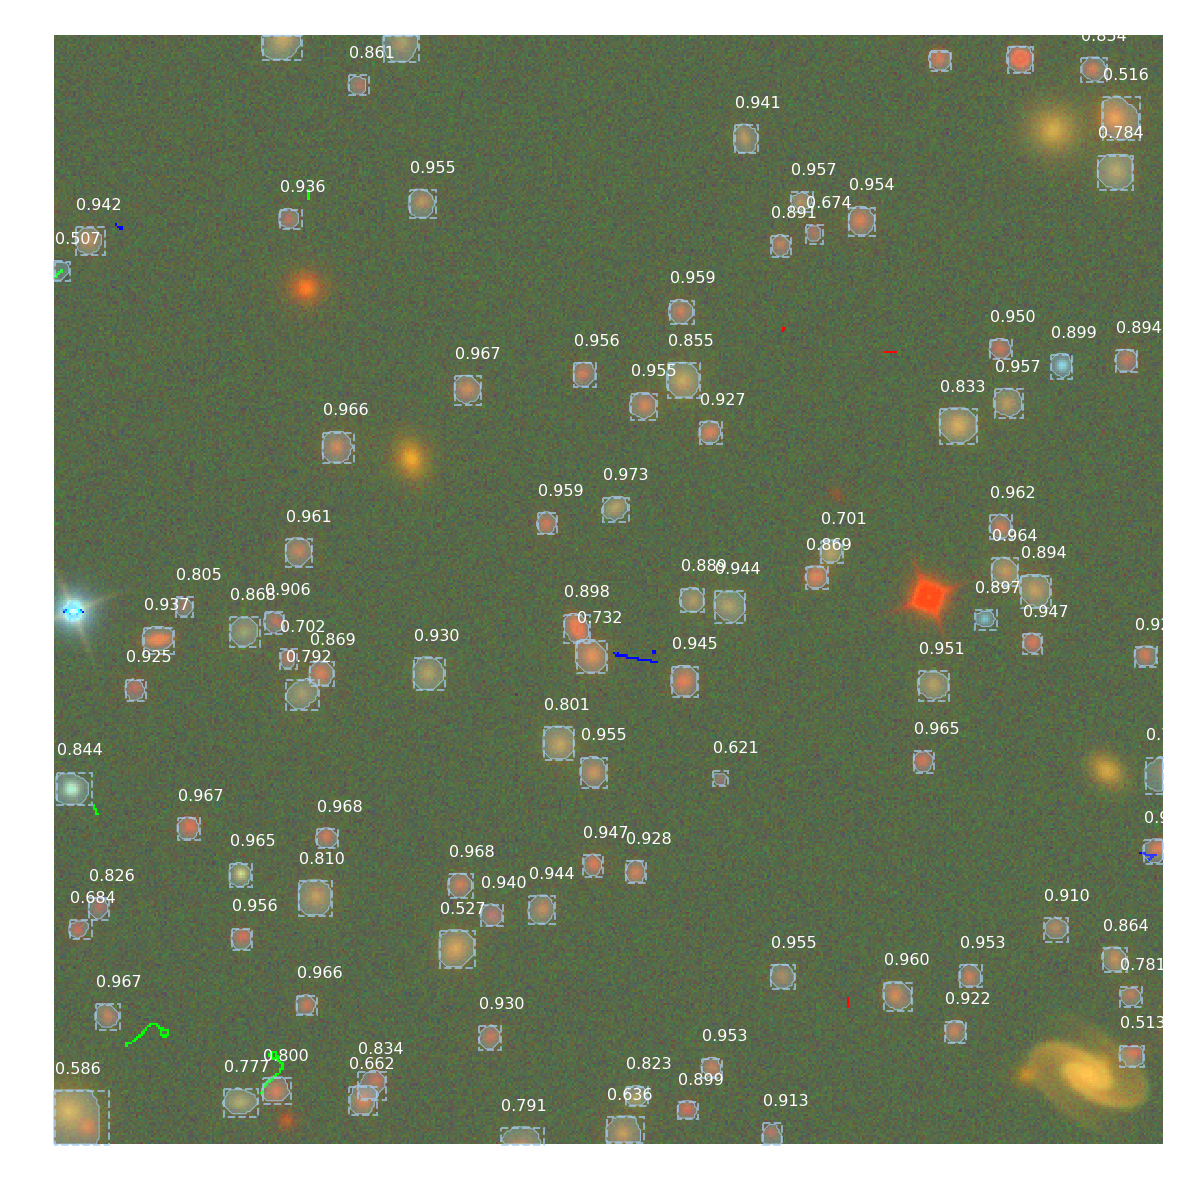

In [8]:
# Test on a random image

image_id = np.random.choice(dataset_test.image_ids)

# Test inference
image = dataset_test.load_image(image_id)
results = model.detect([0.01*image], verbose=1)
r = results[0]


image_raw = dataset_test.load_image(image_id, raw=True)
im_disp = make_lupton_rgb(image_raw[:,:,0]/1.2, image_raw[:,:,1], image_raw[:,:,2], minimum=0, stretch=50, Q=10) #test values
visualize.display_instances(im_disp, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'],save_fig=False)

## Deblending comparison

We will compare close blends with SCARLET using the purity metric:

$$ \rho_k = \frac{\sum{G_k G_k}}{G_k(G_1 + G_2 + ...)}$$

See https://project.lsst.org/meetings/lsst2018/sites/lsst.org.meetings.lsst2018/files/Blending%20Session%205%20%28Tools%20and%20Data%20Sets%29%20-%20Slides_0.pdf#page=13&zoom=100,0,0

### Get predicted Masks

In [11]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_test.class_names)[det_class_ids]))

detections               shape: (1, 300, 6)           min:    0.00000  max:    2.00000  float32
masks                    shape: (1, 300, 28, 28, 3)   min:    0.00000  max:    1.00000  float32
84 detections: ['galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy'
 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy'
 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy'
 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy'
 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy'
 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy'
 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'star'
 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy'
 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy'
 'galaxy' 'star' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy'
 'galaxy' 'galaxy' 'galaxy' 'galaxy']


In [22]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (84, 28, 28)          min:    0.00000  max:    1.00000  float32
det_masks                shape: (84, 512, 512)        min:    0.00000  max:    1.00000  bool


In [12]:
def unmold_mask_astro(mask, bbox, image_shape, threshold=0.5):
    """Converts a mask generated by the neural network to a format similar
    to its original shape.
    mask: [height, width] of type float. A small, typically 28x28 mask.
    bbox: [y1, x1, y2, x2]. The box to fit the mask in.
    Returns a float mask with the same size as the original image.
    """
    y1, x1, y2, x2 = bbox
    mask = utils.resize(mask, (y2 - y1, x2 - x1))
    mask = np.array(mask)
    #mask[mask < threshold] = 0

    # Put the mask in the right location.
    full_mask = np.zeros(image_shape[:2])
    
    full_mask[y1:y2, x1:x2] = mask
    return full_mask

Processing 1 images
image                    shape: (512, 512, 3)         min: -327.64000  max:  327.67000  float64
molded_images            shape: (1, 512, 512, 3)      min: -127.64001  max:  527.67001  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
Done in 0.12 seconds.


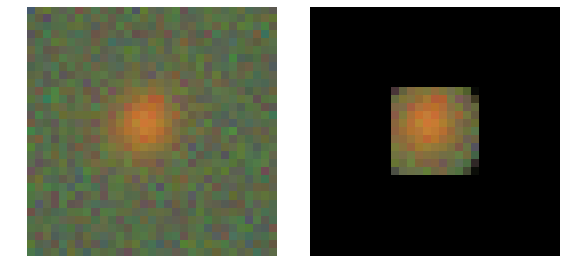

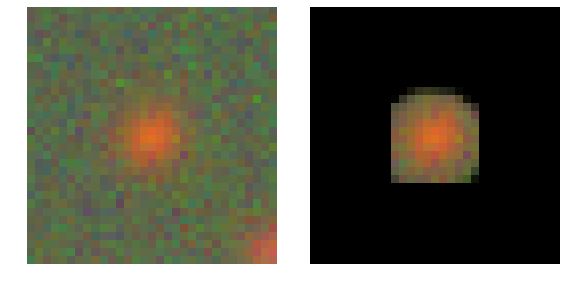

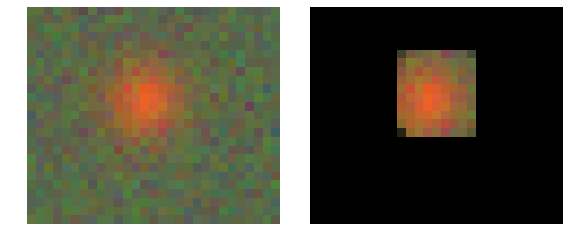

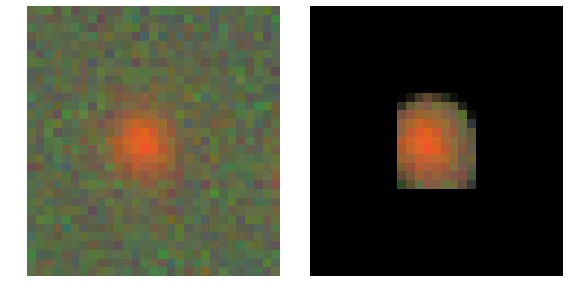

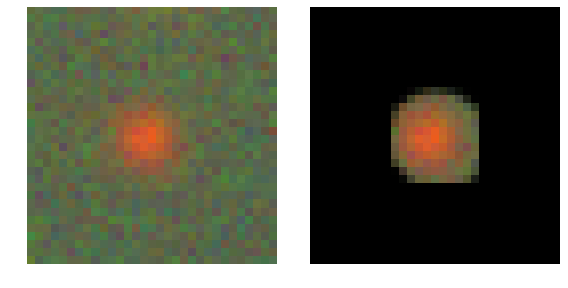

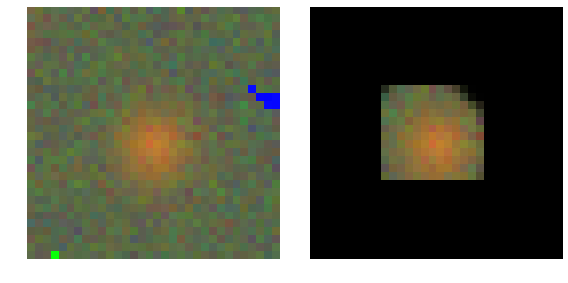

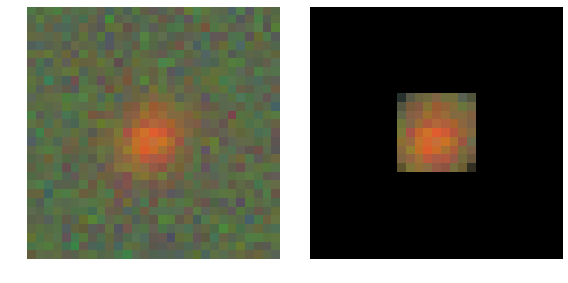

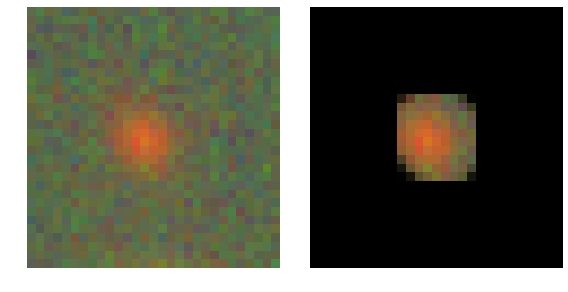

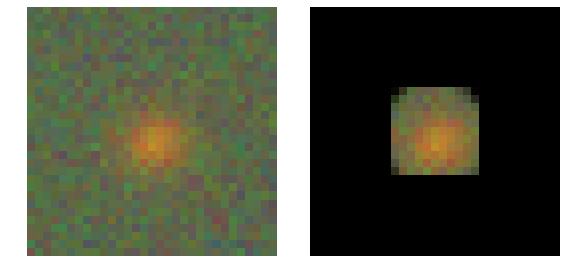

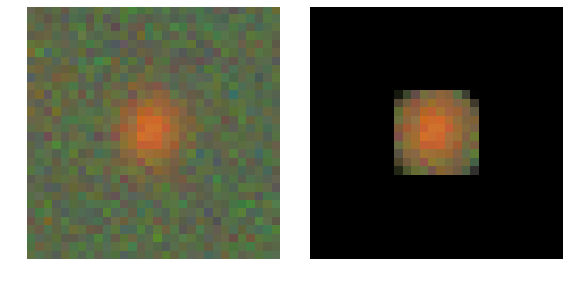

In [15]:
# Test on a random image
image_id = 0
pad = 10

# Test inference
image = dataset_test.load_image(image_id)
results = model.detect([0.01*image], verbose=1)
r = results[0]

image_raw = dataset_test.load_image(image_id, raw=True)

# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])

# Multiply the image by the mask to recover the deblended source
for i, m in enumerate(det_mask_specific[:10]):
        
    det_mask = unmold_mask_astro(m, det_boxes[i], image.shape, threshold=0.5)
    
    r = image_raw[:,:,0]/1.2
    g = image_raw[:,:,1]
    b = image_raw[:,:,2]
    
    fig, ax = plt.subplots(1,2, figsize=(8,5))

    im_disp_in = make_lupton_rgb(r, g, b, minimum=0, stretch=50, Q=10)
    im_disp_deblend = make_lupton_rgb(r*det_mask, g*det_mask, b*det_mask, minimum=0, stretch=50, Q=10)
    
    y1, x1, y2, x2 = det_boxes[i]
    y1 = np.clip(y1-pad, 0, np.shape(im_disp_in)[0])
    x1 = np.clip(x1-pad, 0, np.shape(im_disp_in)[1])
    y2 = np.clip(y2+pad, 0, np.shape(im_disp_in)[0])
    x2 = np.clip(x2+pad, 0, np.shape(im_disp_in)[1])
    
    # Compute metric on each source G_k
    # Compute rho_k
    
    # Plot
    ax[0].imshow(im_disp_in[y1:y2,x1:x2])
    ax[1].imshow(im_disp_deblend[y1:y2,x1:x2])
    ax[0].axis('off')
    ax[1].axis('off')
    fig.tight_layout()
    fig.show()

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [17]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 512, 512, 3)      min: -32564.00000  max: 32967.00000  float32
res2c_out                shape: (1, 128, 128, 256)    min:    0.00000  max: 3400.85791  float32
res3c_out                shape: (1, 64, 64, 512)      min:    0.00000  max: 2564.80200  float32
rpn_bbox                 shape: (1, 65472, 4)         min:  -20.51676  max:   67.30922  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


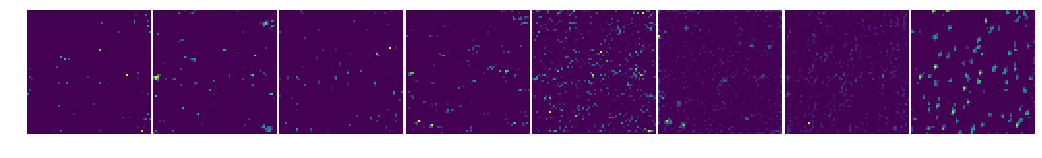

In [20]:
# Backbone feature map
visualize.display_images(np.transpose(activations["res3c_out"][0,:,:,504:512], [2, 0, 1]), cols=8)